# Solve Burgers' equation based on Spectral Neural Operator

[![DownloadNotebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindflow/en/data_driven/mindspore_burgers_SNO1D.ipynb)&emsp;[![DownloadCode](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindflow/en/data_driven/mindspore_burgers_SNO1D.py)&emsp;[![View Source On Gitee](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source_en.svg)](https://gitee.com/mindspore/docs/blob/master/docs/mindflow/docs/source_en/data_driven/burgers_SNO1D.ipynb)


## Overview

Computational fluid dynamics is one of the most important techniques in the field of fluid mechanics in the 21st century. The flow analysis, prediction and control can be realized by solving the governing equations of fluid mechanics by numerical method. Traditional finite element method (FEM) and finite difference method (FDM) are inefficient because of the complex simulation process (physical modeling, meshing, numerical discretization, iterative solution, etc.) and high computing costs. Therefore, it is necessary to improve the efficiency of fluid simulation with AI.

Machine learning methods provide a new paradigm for scientific computing by providing a fast solver similar to traditional methods. Classical neural networks learn mappings between finite dimensional spaces and can only learn solutions related to a specific discretization. Different from traditional neural networks, Fourier Neural Operator (FNO) is a new deep learning architecture that can learn mappings between infinite-dimensional function spaces. It directly learns mappings from arbitrary function parameters to solutions to solve a class of partial differential equations.  Therefore, it has a stronger generalization capability. More information can be found in the paper, [Fourier Neural Operator for Parametric Partial Differential Equations](https://arxiv.org/abs/2010.08895).

Spectral Neural Operator (SNO) is the FNO-like architecture using polynomial transformation to spectral space (Chebyshev, Legendre, etc.) instead of Fourier.
SNO is characterized by smaller systematic bias caused by aliasing errors compared to FNO. One of the most important benefits of the architecture is that SNO supports multiple choice of basis, so it is possible to find a set of polynomials which is the most convenient for representation, e.g., respect symmetries of the problem or fit well into the solution interval. Besides, the neural operators, based on orthogonal polynomials, may be competitive with other spectral operators in case when the input function is defined on unstructured grid.

More information can be found in the paper, "[Spectral Neural Operators](https://arxiv.org/abs/2205.10573)". arXiv preprint arXiv:2205.10573 (2022).

This tutorial describes how to solve the 1-d Burgers' equation using Spectral neural operator.

## Burgers' equation

The 1-d Burgers’ equation is a non-linear PDE with various applications including modeling the one
dimensional flow of a viscous fluid. It takes the form

$$
\partial_t u(x, t)+\partial_x (u^2(x, t)/2)=\nu \partial_{xx} u(x, t), \quad x \in(0,1), t \in(0, 1]
$$

$$
u(x, 0)=u_0(x), \quad x \in(0,1)
$$

where $u$ is the velocity field, $u_0$ is the initial condition and $\nu$ is the viscosity coefficient.


## Problem Description

We aim to learn the operator mapping the initial condition to the solution at time one:

$$
u_0 \mapsto u(\cdot, 1)
$$

## Technology Path

MindFlow solves the problem as follows:

1. Training Dataset Construction.
2. Model Construction.
3. Optimizer and Loss Function.
4. Model Training.

## Spectral Neural Operator

The following figure shows the architecture of the Spectral Neural Operator, which consists of encoder, multiple spectral convolution layers (linear transformation in space of coefficients in polynomial basis) and decoder.
To compute forward and inverse polynomial transformation matrices for spectral convolutions, the input should be interpolated at the respective Gauss quadrature nodes (Chebyshev grid, etc.).
The interpolated input is lifted to a higher dimension channel space by a convolutional Encoder layer. The result comes to the input of a sequence of spectral (SNO) layers, each of which applies a linear convolution to its truncated spectral representation. The output of SNO layers is projected back to the target dimension by a convolutional Decoder, and finally interpolated back to the original nodes.

The spectral (SNO) layer performs the following operations: applies the polynomial transformation $A$ to spectral space (Chebyshev, Legendre, etc.); a linear convolution $L$ on the lower polynomial modes and filters out the higher modes; then applies the inverse conversion $S={A}^{-1}$ (back to the physical space). Then a linear convolution $W$ of input is added, and nonlinear activation is applied.

![Spectral Neural Operator model structure](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindflow/docs/source_en/data_driven/images/SNO.png)

In [1]:
import os
import time
import numpy as np

from mindspore import context, nn, Tensor, set_seed, ops, data_sink, jit, save_checkpoint
from mindspore import dtype as mstype
from mindflow.cell import SNO1D, get_poly_transform
from mindflow import RelativeRMSELoss, load_yaml_config, get_warmup_cosine_annealing_lr
from mindflow.pde import UnsteadyFlowWithLoss
from mindflow.utils import print_log

The following `src` pacakage can be downloaded in [applications/data_driven/burgers/sno1d/src](https://gitee.com/mindspore/mindscience/tree/master/MindFlow/applications/data_driven/burgers/sno1d/src).

In [2]:
from src import create_training_dataset, load_interp_data, test_error, visual

set_seed(0)
np.random.seed(0)

context.set_context(mode=context.GRAPH_MODE, device_target="GPU", device_id=0)
use_ascend = context.get_context(attr_key='device_target') == "Ascend"

You can get parameters of model, data and optimizer from `config`.

In [4]:
config = load_yaml_config('./configs/sno1d.yaml')
data_params = config["data"]
model_params = config["model"]
optimizer_params = config["optimizer"]
summary_params = config["summary"]

## Training Dataset Construction

Download the training and test dataset: [data_driven/burgers/dataset](https://download.mindspore.cn/mindscience/mindflow/dataset/applications/data_driven/burgers/dataset/) .

In this case, training datasets and test datasets are generated according to Zongyi Li's dataset in [Fourier Neural Operator for Parametric Partial Differential Equations](https://arxiv.org/pdf/2010.08895.pdf) . The settings are as follows:

the initial condition $u_0(x)$ is generated according to periodic boundary conditions:

$$
u_0 \sim \mu, \mu=\mathcal{N}\left(0,625(-\Delta+25 I)^{-2}\right)
$$

We set the viscosity to $\nu=0.1$ and solve the equation using a split step method where the heat equation part is solved exactly in Fourier space then the non-linear part is advanced, again in Fourier space, using a very fine forward Euler method. The number of samples in the training set is 1000, and the number of samples in the test set is 200.


In [5]:
poly_type = data_params['poly_type']

# create training dataset
load_interp_data(data_params, dataset_type='train')
train_dataset = create_training_dataset(data_params, shuffle=True)

# create test dataset
test_data = load_interp_data(data_params, dataset_type='test')
test_input = Tensor(test_data['test_inputs'], mstype.float32)
test_label = Tensor(test_data['test_labels'], mstype.float32)

## Model Construction

The network is composed of 1 encoding layer, multiple spectral layers and decoding block:

- The encoding convolution corresponds to the `SNO1D.encoder` in the case, and maps the input data $x$ to the high dimension;

- A sequence of SNO layers corresponds to the `SNO1D.sno_kernel` in the case. Input matrices of polynomial transformation(forward and inverse conversions) are used to realize the transition between space-time domain and frequency domain;

- The decoding layer corresponds to `SNO1D.decoder` and consists of two convolutions.The decoder is used to obtain the final prediction.

The initialization of the model based on the network above, parameters can be modified in [configuration file](https://gitee.com/mindspore/mindscience/blob/master/MindFlow/applications/data_driven/burgers/sno1d/configs/sno1d.yaml).

In [6]:
n_modes = model_params['modes']
resolution = data_params['resolution']

transform_data = get_poly_transform(resolution, n_modes, poly_type)

transform = Tensor(transform_data["analysis"], mstype.float32)
inv_transform = Tensor(transform_data["synthesis"], mstype.float32)

In [7]:
model = SNO1D(in_channels=model_params['in_channels'],
              out_channels=model_params['out_channels'],
              hidden_channels=model_params['hidden_channels'],
              num_sno_layers=model_params['sno_layers'],
              transforms=[[transform, inv_transform]],
              compute_dtype=mstype.float32)

model_params_list = []
for k, v in model_params.items():
    model_params_list.append(f"{k}:{v}")
model_name = "_".join(model_params_list)
print(model_name)
total = 0
for param in model.get_parameters():
    print_log(param.shape)
    total += param.size
print_log(f"Total Parameters:{total}")

root_dir:./_name:SNO1D_in_channels:1_out_channels:1_hidden_channels:128_sno_layers:6_modes:15
(128, 1, 1, 1)
(128, 128, 1, 5)
(128, 128, 1, 1)
(128, 128, 1, 5)
(128, 128, 1, 1)
(128, 128, 1, 5)
(128, 128, 1, 1)
(128, 128, 1, 5)
(128, 128, 1, 1)
(128, 128, 1, 5)
(128, 128, 1, 1)
(128, 128, 1, 5)
(128, 128, 1, 1)
(128, 128, 1, 1)
(1, 128, 1, 1)
Total Parameters:606464


## Optimizer and Loss Function

In [8]:
steps_per_epoch = train_dataset.get_dataset_size()

lr = get_warmup_cosine_annealing_lr(lr_init=optimizer_params["learning_rate"],
                                    last_epoch=optimizer_params["epochs"],
                                    steps_per_epoch=steps_per_epoch,
                                    warmup_epochs=1)

optimizer = nn.AdamWeightDecay(model.trainable_params(), learning_rate=Tensor(lr),
                               weight_decay=optimizer_params['weight_decay'])

## Model Training

With **MindSpore version >= 2.0.0**, we can use the functional programming for training neural networks. `MindFlow` provide a training interface for unsteady problems `UnsteadyFlowWithLoss` for model training and evaluation.

In [9]:
problem = UnsteadyFlowWithLoss(model, loss_fn=RelativeRMSELoss(), data_format="NTCHW")

def forward_fn(data, label):
    loss = problem.get_loss(data, label)
    return loss

grad_fn = ops.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=False)

@jit
def train_step(data, label):
    loss, grads = grad_fn(data, label)
    grads = ops.clip_by_global_norm(grads, optimizer_params['grad_clip_norm'])

    loss = ops.depend(loss, optimizer(grads))
    return loss

sink_process = data_sink(train_step, train_dataset, 1)

summary_dir = summary_params["summary_dir"]
os.makedirs(summary_dir, exist_ok=True)
ckpt_dir = summary_params['ckpt_dir']
os.makedirs(ckpt_dir, exist_ok=True)

for epoch in range(1, optimizer_params["epochs"] + 1):
    local_time_beg = time.time()
    model.set_train(True)
    for _ in range(steps_per_epoch):
        cur_loss = sink_process()

    if epoch % 2 == 0:
        print_log(f"epoch: {epoch} train loss: {cur_loss.asnumpy()} epoch time: {time.time() - local_time_beg:.2f}s")

    model.set_train(False)
    if epoch % summary_params["save_ckpt_interval"] == 0:
        save_checkpoint(model, os.path.join(ckpt_dir, f"{model_params['name']}_epoch{epoch}"))

    if epoch % summary_params['test_interval'] == 0:
        test_error(model, test_input, test_label, data_params)

epoch: 2 train loss: 13.560559272766113 epoch time: 0.29s
epoch: 4 train loss: 7.8073320388793945 epoch time: 0.29s
epoch: 6 train loss: 5.312091827392578 epoch time: 0.29s
epoch: 8 train loss: 4.512760162353516 epoch time: 0.29s
epoch: 10 train loss: 4.524318695068359 epoch time: 0.29s
================================Start Evaluation================================
poly err 0.082584664 unif err 0.08160467609741283
mean rel_rmse_error:
on Gauss grid: 0.082584664, on regular grid: 0.08160467609741283
=================================End Evaluation=================================
predict total time: 0.9047303199768066 s
epoch: 12 train loss: 3.368042230606079 epoch time: 0.29s
epoch: 14 train loss: 3.7890400886535645 epoch time: 0.29s
epoch: 16 train loss: 2.914067268371582 epoch time: 0.29s
epoch: 18 train loss: 3.0474812984466553 epoch time: 0.29s
epoch: 20 train loss: 2.3820204734802246 epoch time: 0.29s
================================Start Evaluation================================

In [10]:
visual(model, test_input, data_params)

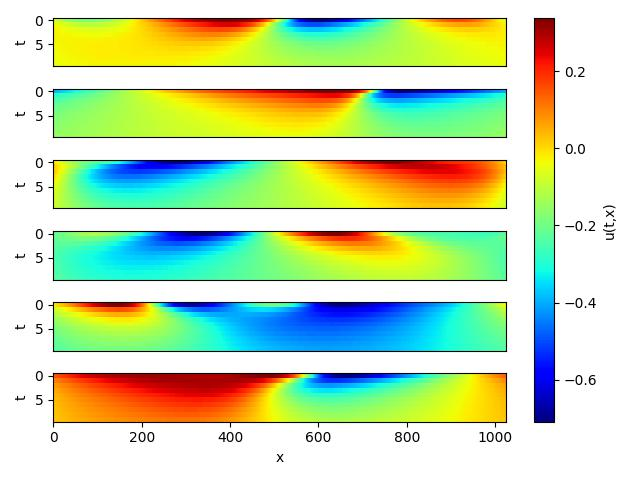

In [12]:
from IPython.display import Image, display

display(Image(filename='images/result.jpg', embed=True))